In [153]:
import networkx as nx
import pandas as pd
import json

from matplotlib import pyplot as plt
from collections.abc import Mapping
from typing import Any, Literal
from itertools import product
from pathlib import Path
from math import isnan

In [154]:
def load_records(result_file_name: str) -> list[Mapping[str, Any]]:
    records: list[Mapping[str, Any]] = []
    with open(Path("./results") / result_file_name, 'r') as file:
        dpth: int = 0
        buff: list[str] = []
        for raw in file:
            line = raw.strip()
            if not line:
                continue
            dpth += line.count('{')
            dpth -= line.count('}')
            buff.append(raw)
            if dpth == 0 and buff:
                chunk = ''.join(buff)
                obj = json.loads(chunk)
                records.append(obj)
                buff = []
    return records

In [155]:
def best_record(records: list[Mapping[str, Any]]) -> Mapping[str, Any]:
    best: Mapping[str, Any] = {}
    for record in records:
        for uid, details in record.items():
            if not best or details['score'] < best['score']:
                best = {'id': uid, **details}
    return best

In [156]:
def load_config(result_file_name: str) -> Mapping[str, Any]:
    stem = Path(result_file_name).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config

In [157]:
def load_experiment(experiment_name: str) -> Mapping[str, Any]:
    result_file_name = f"result_{experiment_name}.jsonl"
    records = load_records(result_file_name)
    best = best_record(records)
    best["real_tracks"] = best.get("total_tracks", float("nan")) - best.get("total_tracks", float("nan")) * ((best["event_avg_ghost_rate"] / 100.) + (best["clone_percentage"] / 100.) - (best["event_avg_ghost_rate"] / 100.) * (best["clone_percentage"] / 100.))
    config = load_config(result_file_name)
    return {
        "name": experiment_name,
        "result": best,
        "config": config
    }

In [158]:
def load_all_experiments() -> list[Mapping[str, Any]]:
    experiments: list[Mapping[str, Any]] = []
    for result_file in Path("./results").glob("result_*.jsonl"):
        experiment_name = result_file.stem.removeprefix("result_")
        experiment = load_experiment(experiment_name)
        if isnan(experiment["result"]["real_tracks"]):
            continue
        experiments.append(experiment)
    return experiments

In [159]:
def only_experiments_with(algorithm: Literal["ST", "TF", "GDFS"], weights: tuple[float, float, float, float]) -> list[Mapping[str, Any]]:
    experiments = load_all_experiments()
    filtered: list[Mapping[str, Any]] = []
    for experiment in experiments:
        config = experiment["config"]
        optimizer = config["optimizer"]
        if config["reconstruction_algo"] == algorithm and optimizer["weights"] == list(weights):
            filtered.append(experiment)
    return filtered

In [160]:
def extract_label(experiment: Mapping[str, Any]) -> str:
    solver = experiment["config"]["solverName"]
    match solver:
        case "Bayesian":
            solver = "BA"
        case "ParticleSwarm":
            solver = "PSO"
        case "GridSearch":
            solver = "GS"
        case "PolyHoot":
            solver = "PH"
        case _:
            pass
    algorithm = experiment["config"]["reconstruction_algo"]
    hyperparams = experiment["config"]["optimizer"]
    hyperparams = {k: v for k, v in hyperparams.items() if k not in ["max_iterations", "objective", "nested"]}
    proto_label = {
        "solver": solver
    }
    return json.dumps(proto_label, sort_keys=True)

In [161]:
all_algorithms: list[str] = ["ST", "TF"]
all_weights: list[tuple[float, float, float, float]] = [
    (0.1, 0.3, 0.5, -10.0),
    (0.01, 0.5, 0.5, -7.0),
    (0.4, 0.2, 0.5, -7.0),
    (0.4, 0.2, 0.3, -5.0),
]
all_experiments = []
for algorithm, weights in product(all_algorithms, all_weights):
    filtered_experiments = only_experiments_with(algorithm, weights)
    all_experiments.extend(filtered_experiments)
len(all_experiments)

80

In [162]:
print(json.dumps(all_experiments[70], indent=2))

{
  "name": "ParticleSwarm_ST_3_72880cfe-a2dc-498e-98c7-4cbce0341b33",
  "result": {
    "id": "e61f2922-703c-4ad7-a9d5-bb44ef1af8b8",
    "params": {
      "scatter": 7.829422865502203e-10,
      "min_strong_track_length": 4,
      "allowed_missed_modules": 3
    },
    "score": 895.7088094551559,
    "total_ghosts": 11,
    "overall_ghost_rate": 0.3685092127303183,
    "event_avg_ghost_rate": 0.33758968041704557,
    "clone_percentage": 9.599754402387175,
    "total_tracks": 2985,
    "time": 0.3377690315246582,
    "real_tracks": 2689.337651367498
  },
  "config": {
    "solverName": "ParticleSwarm",
    "reconstruction_algo": "ST",
    "num_events": 100,
    "intra_node": true,
    "max_runs": 1000,
    "optimizer": {
      "inertia": 0.5,
      "cognitive": 1.5,
      "social": 1.5,
      "max_iterations": 1000,
      "objective": "min",
      "nested": false,
      "weights": [
        0.4,
        0.2,
        0.3,
        -5.0
      ],
      "swarm_size": 20
    }
  }
}


In [163]:
real_tracks_list = {}
label_to_experiment = {}
for experiment in all_experiments:
    label = extract_label(experiment)
    real_tracks = experiment["result"]["real_tracks"]
    if label not in real_tracks_list:
        real_tracks_list[label] = []
        label_to_experiment[label] = experiment
    real_tracks_list[label].append(real_tracks)
avg_real_tracks = {label: sum(tracks) / len(tracks) for label, tracks in real_tracks_list.items()}
avg_real_tracks

{'{"solver": "BA"}': 32715.42348793528,
 '{"solver": "GS"}': 33292.34955215504,
 '{"solver": "PSO"}': 10399.60044442563,
 '{"solver": "PH"}': 20778.474255617508}

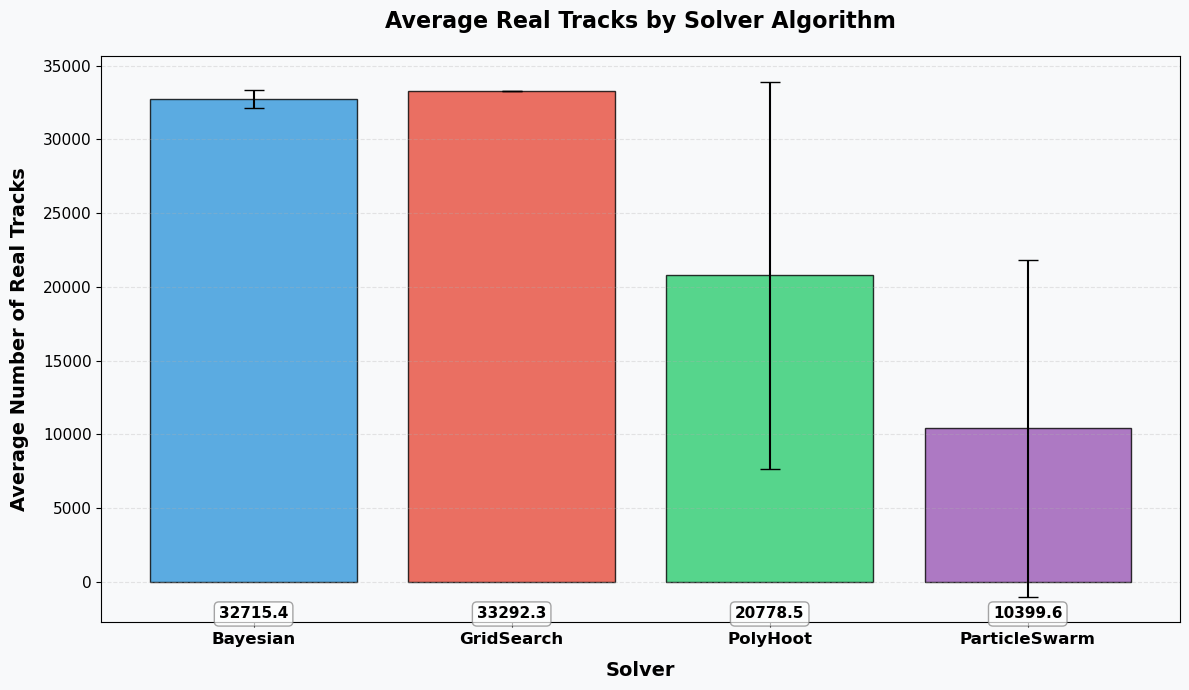

In [164]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Parse the labels and prepare data for plotting
solvers = []
values = []
std_devs = []

# Sort items by solver name for consistency
for label_json, avg_value in sorted(avg_real_tracks.items(), key=lambda x: json.loads(x[0])["solver"]):
    label_dict = json.loads(label_json)
    solver = label_dict["solver"]
    
    # Convert abbreviations back to full names
    solver_full_name = {
        "BA": "Bayesian",
        "PSO": "ParticleSwarm",
        "GS": "GridSearch",
        "PH": "PolyHoot"
    }.get(solver, solver)
    
    solvers.append(solver_full_name)
    values.append(avg_value)
    
    # Calculate standard deviation
    std_dev = np.std(real_tracks_list[label_json])
    std_devs.append(std_dev)

# Create the bar chart with error bars
plt.figure(figsize=(12, 7))
bars = plt.bar(solvers, values, yerr=std_devs, capsize=7, 
               color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'], 
               alpha=0.8, edgecolor='black', linewidth=1)

# Add data labels below each bar
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        -max(values) * 0.05,  # Position below x-axis
        f'{value:.1f}',
        ha='center', va='top',
        fontsize=11, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3', edgecolor='gray')
    )

# Add title and labels
plt.title('Average Real Tracks by Solver Algorithm', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Solver', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Average Number of Real Tracks', fontsize=14, fontweight='bold', labelpad=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)

# Add a light background color
plt.gca().set_facecolor('#f8f9fa')
plt.gcf().set_facecolor('#f8f9fa')

# Improve styling
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=11)

# Add bottom padding to make room for labels
plt.subplots_adjust(bottom=0.15)

plt.tight_layout()
plt.show()

In [ ]:
def extract_label(experiment: Mapping[str, Any]) -> str:
    solver = experiment["config"]["solverName"]
    match solver:
        case "Bayesian":
            solver = "BA"
        case "ParticleSwarm":
            solver = "PSO"
        case "GridSearch":
            solver = "GS"
        case "PolyHoot":
            solver = "PH"
        case _:
            pass
    algorithm = experiment["config"]["reconstruction_algo"]
    hyperparams = experiment["config"]["optimizer"]
    hyperparams = {k: v for k, v in hyperparams.items() if k not in ["max_iterations", "objective", "nested"]}
    proto_label = {
        "algorithm": algorithm
    }
    return json.dumps(proto_label, sort_keys=True)

In [ ]:
real_tracks_list = {}
label_to_experiment = {}
for experiment in all_experiments:
    label = extract_label(experiment)
    real_tracks = experiment["result"]["real_tracks"]
    if label not in real_tracks_list:
        real_tracks_list[label] = []
        label_to_experiment[label] = experiment
    real_tracks_list[label].append(real_tracks)
avg_real_tracks = {label: sum(tracks) / len(tracks) for label, tracks in real_tracks_list.items()}
avg_real_tracks